# Compass Calibration

**I2c Chip:** HMC5883L

This notebook helps understand the range of values collected from the HMC5883L accelerometer and is used to assist in discovering ways to improve and calibrate the readings.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
import math
import random

# Raw coordinates

This section is dedicated to extrapolating information from the raw coordinates. The goal is to ensure Y (or rotation, whichever axis that is) does not change at all when loading the `data_xyzm_raw_hzonly.json` file. This file contains data where the sensor was rotated along the x axis (like a compass) with zero rotation. Use the findings here to generate a calibration strategy and then in the next section, apply that strategy to explore how to keep the rotation axis still no matter the heading.

In [3]:
def heading(x,y,z):
    deg = np.degrees(math.atan2(z,x))
    if deg < 0:
        deg = 360 - abs(deg)
    return deg % 360


def closest_factor(y_factor, heading):
    closest_key = 4096
    closest_val = 0.0
    for k,v in y_factor.items():
        difference = abs(heading - k)
        if difference < closest_key:
            closest_key = difference
            closest_val = v
    return closest_val


def dist(x, z):
    return abs(x - z)


def apply_calibration(y_factor, x, y, z):
    ax = []
    ay = []
    az = []
    
    for idx in range(0, len(x)):
        px = x[idx]
        py = y[idx]
        pz = z[idx]
        h = int(heading(px, py, pz))
        
        mult_factor = closest_factor(y_factor, h)
        py = py * mult_factor
            
        if py > 10:
            py /= 10
        
        ax.append(px)
        ay.append(py)
        az.append(pz)
        
    return (np.asarray(ax), np.asarray(ay), np.asarray(az))


def zed(val):
    if val == 0:
        return 1.0
    else:
        return val

# Heading Calibration

In order to calibrate the heading, we need to plot x and z axis after they have been

corrected in the `load_data` step.

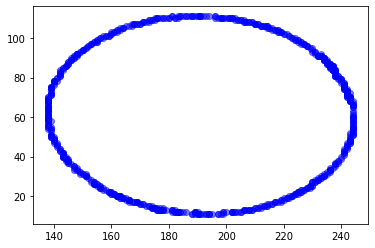

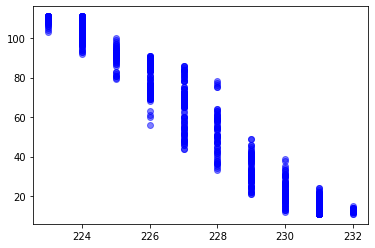

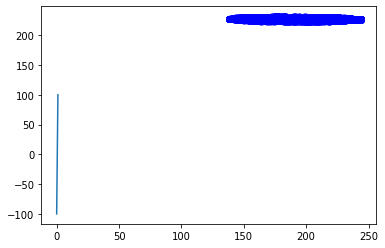

In [237]:
def load_data(path, x_offset=191, y_offset=321, z_offset=19, perc=1.0):
    with open(path) as f:
        data = json.load(f)
    data = random.sample(data, int(len(data) * perc))
    arr = np.asarray(data, dtype=np.float32)
    arr = arr[np.argsort(arr[:, 3])]
    x = arr[:,0] + x_offset
    y = arr[:,1] + y_offset
    z = arr[:,2] + z_offset
    t = arr[:,3]
    
    return (x,y,z,t)

x_offset, y_offset, z_offset = 200.0, 369.0, 70.0 #50.0, 197.0, 21.0
x,y,z,t = load_data('data_xyzm_raw_hzonly.json', x_offset=x_offset, y_offset=y_offset, z_offset=z_offset, perc=1.0)

# There is a positive correlation between heading and x/z
plt.scatter(x, z, alpha=0.5, color='blue')
plt.show()

plt.scatter(y, z, alpha=0.5, color='blue')
plt.show()

plt.scatter(x, y, alpha=0.5, color='blue')
plt.plot([-100,100])
plt.show()

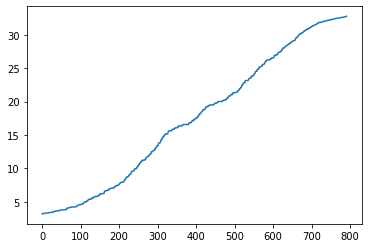

In [238]:
# Determine the heading for each point
headings = []
for idx in range(0, len(x)):
    px = x[idx]
    py = y[idx]
    pz = z[idx]
    h = heading(px,py,pz)
    headings.append(h)
    
headings = np.sort(headings)

plt.plot(headings)
plt.show()

    

# Calibration

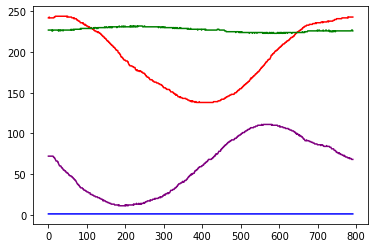

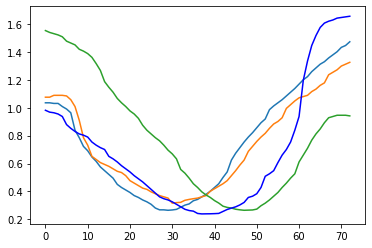

In [239]:
# x,y,z,t = load_data('data_full_hz_10deg_tilt_backwards.json', 1.0)

def generate_calibration(cal_list_x, cal_list_y, cal_list_z):
    y_factor = {}
    y_factor_count = {}
    for idx in range(0, len(cal_list_y)):
        px = cal_list_x[idx]
        py = cal_list_y[idx]
        pz = cal_list_z[idx]
        h = round(heading(px,py,pz))

        if round(py) == 0:
            factor = 1.0
        else:
            factor = (1 / py)

        if h in y_factor:
            y_factor[h] += factor
            y_factor_count[h] += 1.0
        else:
            y_factor[h] = factor
            y_factor_count[h] = 1.0

    for k in y_factor.keys():
        y_factor[k] /= y_factor_count[k]
    
    return y_factor

y_factor = generate_calibration(x,y,z)

y_adj = []
for idx in range(0, len(y)):
    px = x[idx]
    py = y[idx]
    pz = z[idx]
    h = int(heading(px,py,pz))
    y_adj.append(py * closest_factor(y_factor, h))

plt.plot(x, color='red')
plt.plot(y_adj, color='blue')
plt.plot(y, color='green')
plt.plot(z, color='purple')
plt.show()

# fc = fully calibrated
x4, y4, z4, t4 = load_data('data_xyzm_vq1.json')
x5, y5, z5, t5 = load_data('data_xyzm_vq2.json')
x6, y6, z6, t6 = load_data('data_xyzm_vq3.json')
x7, y7, z7, t7 = load_data('data_xyzm_vq4.json')

fc_x4, fc_y4, fc_z4 = apply_calibration(y_factor, x4, y4, z4)
fc_x5, fc_y5, fc_z5 = apply_calibration(y_factor, x5, y5, z5)
fc_x6, fc_y6, fc_z6 = apply_calibration(y_factor, x6, y6, z6)
fc_x7, fc_y7, fc_z7 = apply_calibration(y_factor, x7, y7, z7)

factor = 1.0
plt.plot(fc_y4*factor)
plt.plot(fc_y5*factor)
plt.plot(np.flip(fc_y6)*factor)
plt.plot(np.flip(fc_y7)*factor, color='blue')
plt.show()



# Correlation between rotation and other dimensions

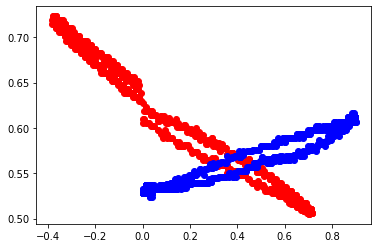

In [240]:
debug_x, debug_y, debug_z, debug_t = load_data('data_xyzm_debug_hz.json', x_offset=x_offset, y_offset=y_offset, z_offset=z_offset, perc=1.0)
debug_cx, debug_cy, debug_cz = apply_calibration(y_factor, debug_x, debug_y, debug_z)

# tilted_x, tilted_y, tilted_z, tilted_t = load_data('data_full_hz_10deg_tilt_backwards.json')
tilted_x, tilted_y, tilted_z, tilted_t = load_data('data_full_hz_10deg_tilt_fwd_double.json', x_offset=x_offset, y_offset=y_offset, z_offset=z_offset, perc=1.0)
tilted_cal_cx, tilted_cal_cy, tilted_cal_cz = apply_calibration(y_factor, tilted_x, tilted_y, tilted_z)

tilted_bwd_rev_x, tilted_bwd_rev_y, tilted_bwd_rev_z, tilted_bwd_t = load_data('data_full_hz_10deg_tilt_backwards_rev.json', x_offset=x_offset, y_offset=y_offset, z_offset=z_offset, perc=1.0)
tilted_bwd_rev_cal_cx, tilted_bwd_rev_cal_cy, tilted_bwd_rev_cal_cz = apply_calibration(y_factor, tilted_bwd_rev_x, tilted_bwd_rev_y, tilted_bwd_rev_z)


tilted_fwd_x, tilted_fwd_y, tilted_fwd_z, _ = load_data('data_full_hz_10deg_tilt_forwards.json', x_offset=x_offset, y_offset=y_offset, z_offset=z_offset, perc=1.0)
tilted_fwd_cal_cx, tilted_fwd_cal_cy, tilted_fwd_cal_cz = apply_calibration(y_factor, tilted_fwd_x, tilted_fwd_y, tilted_fwd_z)


fwd_x = []
bwd_x = []

tilted_h = []
tilted_fwd_h = []

for idx in range(0, len(tilted_y)):
    tilted_h.append(int(heading(tilted_x[idx], tilted_y[idx], tilted_z[idx])))
    bwd_x.append( math.atan2(tilted_z[idx], tilted_y[idx]))

for idx in range(0, len(tilted_fwd_y)):
    tilted_fwd_h.append(int(heading(tilted_fwd_x[idx], tilted_fwd_y[idx], tilted_fwd_z[idx])))
    fwd_x.append( math.atan2(tilted_fwd_z[idx], tilted_fwd_y[idx]))
    
plt.scatter(x=bwd_x, y=tilted_cal_cy, color='red')
plt.scatter(x=fwd_x, y=tilted_fwd_cal_cy, color='blue')
plt.show()


# Verify Calibration Effectiveness


In [241]:
def calc_stats(max_baseline, min_baseline, x_list, y_list, z_list):
    midpoint_baseline = (max_baseline + min_baseline) / 2.0
    perc_outside_baseline = 0
    perc_above_line = 0
    perc_below_line = 0
    perc_inside_line = 0
    
    for idx in range(0, len(y_list)):
        px = x_list[idx]
        py = y_list[idx]
        pz = z_list[idx]
        h = int(heading(px, py, pz))

        if py > max_baseline /2 or py < min_baseline/2:
            perc_outside_baseline += 1
            
            # Calculate quadrant data
            quad = math.atan2(pz, py)
            horizontal_epoch = 1.0
            center_epoch = 0
            if quad < center_epoch and py <  horizontal_epoch or quad > center_epoch and py > horizontal_epoch:
                py = abs(py)
            else:
                py = abs(py) * -1

            if py > 0:
                perc_above_line += 1
            else:
                perc_below_line += 1
        else:
            perc_inside_line += 1
            
    perc_outside_baseline /= len(y_list)
    perc_above_line /= len(y_list)
    perc_below_line /= len(y_list)
    perc_inside_line /= len(y_list)
    
    return (perc_outside_baseline, perc_above_line, perc_below_line, perc_inside_line)


Stats:
-----------------------------
Maximum Baseline 0.5758
Minimum Baseline 0.482


Effectiveness: 71.43%
-----------------------------
(FWD) Perc Positive 0.0%
(FWD) Perc Negative 100.0%
(FWD) Perc Inside Baseline 0.0%

(BWD) Perc Positive 42.86%
(BWD) Perc Negative 57.14%
(BWD) Perc Inside Baseline 0.0%



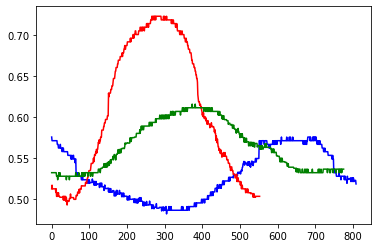

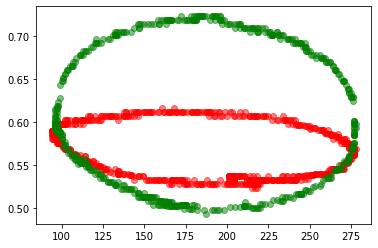

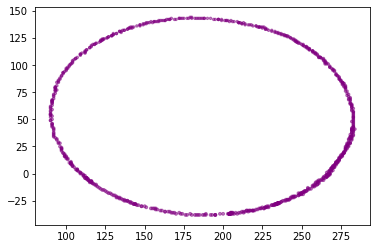

In [242]:
debug_x, debug_y, debug_z, debug_t = load_data('data_xyzm_debug_hz.json', x_offset=x_offset, y_offset=y_offset, z_offset=z_offset, perc=1.0)
debug_cx, debug_cy, debug_cz = apply_calibration(y_factor, debug_x, debug_y, debug_z)

tilted_x, tilted_y, tilted_z, _ = load_data('data_full_hz_10deg_tilt_backwards.json', x_offset=x_offset, y_offset=y_offset, z_offset=z_offset, perc=1.0)
tilted_cal_cx, tilted_cal_cy, tilted_cal_cz = apply_calibration(y_factor, tilted_x, tilted_y, tilted_z)

tilted_fwd_x, tilted_fwd_y, tilted_fwd_z, _ = load_data('data_full_hz_10deg_tilt_forwards.json', x_offset=x_offset, y_offset=y_offset, z_offset=z_offset, perc=1.0)
tilted_fwd_cal_cx, tilted_fwd_cal_cy, tilted_fwd_cal_cz = apply_calibration(y_factor, tilted_fwd_x, tilted_fwd_y, tilted_fwd_z)


# Calculate some statistics
max_baseline = np.round(np.max(debug_cy), 4)
min_baseline = np.round(np.min(debug_cy), 4)

perc_above_line = 0.0
perc_below_line = 0.0
perc_inside_line = 0.0

fwd_outside, fwd_above, fwd_below, fwd_inside = calc_stats(
    max_baseline,
    min_baseline,
    tilted_fwd_cal_cx,
    tilted_fwd_cal_cy,
    tilted_fwd_cal_cz,    
)

bwd_outside, bwd_above, bwd_below, bwd_inside = calc_stats(
    max_baseline,
    min_baseline,
    tilted_cal_cx,
    tilted_cal_cy,
    tilted_cal_cz,    
)

score1 = ((100 * fwd_above) + (100*bwd_below)) / 2
score2 = ((100 * bwd_above) + (100*fwd_below)) / 2

print('')
print('Stats:')
print('-----------------------------')
print('Maximum Baseline ' + str(max_baseline))
print('Minimum Baseline ' + str(min_baseline))
print('')
print('')
print('Effectiveness: ' + str(np.round(max(score1, score2), 2)) + '%')
print('-----------------------------')
print('(FWD) Perc Positive ' + str(np.round(100*fwd_above, 2)) + '%')
print('(FWD) Perc Negative ' + str(np.round(100*fwd_below, 2)) + '%')
print('(FWD) Perc Inside Baseline ' + str(np.round(100*fwd_inside, 2)) + '%')
print('')
print('(BWD) Perc Positive ' + str(np.round(100*bwd_above, 2)) + '%')
print('(BWD) Perc Negative ' + str(np.round(100*bwd_below, 2)) + '%')
print('(BWD) Perc Inside Baseline ' + str(np.round(100*bwd_inside, 2)) + '%')
print('')

plt.plot(debug_cy, color='blue')
plt.plot(tilted_cal_cy, color='red')
plt.plot(tilted_fwd_cal_cy, color='green')
plt.show()

plt.scatter(x=tilted_fwd_cal_cx, y=tilted_fwd_cal_cy, color='red', alpha=0.5)
plt.scatter(x=tilted_cal_cx, y=tilted_cal_cy, color='green', alpha=0.5)
plt.show()

plt.scatter(x=debug_cx, y=debug_cz, s=abs(debug_cy * 5) ** 2, alpha=0.5, color='purple')
plt.show()

# Calibration outputs

In [228]:
calibration_factors = np.ndarray((360))
calibration_str = ''

for i in range(0, 360):
    v = closest_factor(y_factor, i)
    calibration_factors[i] = v
    calibration_str += str(round(calibration_factors[i]* 10000)) + ', '
    
calibration_str

'-213, -215, -213, -213, -213, -211, -208, -208, -204, -208, -206, -204, -204, -202, -200, -200, -200, -200, -202, -196, -196, -196, -196, -196, -196, -196, -192, -196, -192, -192, -192, -192, -192, -190, -189, -189, -189, -189, -189, -189, -189, -189, -189, -189, -187, -188, -185, -189, -185, -185, -185, -185, -185, -185, -185, -185, -185, -185, -185, -185, -185, -185, -185, -185, -185, -185, -185, -185, -185, -185, -185, -189, -185, -185, -185, -185, -185, -185, -185, -185, -189, -189, -187, -189, -185, -189, -189, -189, -189, -189, -192, -189, -190, -190, -190, -192, -192, -192, -192, -192, -196, -192, -196, -196, -196, -196, -196, -196, -196, -196, -200, -200, -200, -196, -200, -200, -200, -201, -204, -204, -200, -204, -204, -204, -204, -204, -204, -208, -208, -208, -208, -213, -213, -208, -208, -208, -208, -213, -213, -213, -213, -213, -217, -217, -217, -217, -217, -217, -217, -222, -222, -222, -222, -222, -222, -222, -222, -222, -222, -222, -227, -227, -227, -227, -227, -227, -22

# Monte Carlo
There exist some initial plane offsets which affect the entire quality of the model. This
section is to surface those offsets through a monte carlo simulation.

In [236]:
random.seed(1337)

def random_offset():
    return np.round((random.random() * 400)) #- (random.random() * 300))

def random_factor():
    return (random.random() * 2) * random.random()

def monte_carlo(runs):
    
    best_effectiveness = 0.0
    best_score = 0.0
    best_offsets = [15,257,15]
    ox, oy, oz, _ = load_data('data_xyzm_raw_hzonly.json', x_offset=0, y_offset=0, z_offset=0)
    o_debug_x, o_debug_y, o_debug_z, _ = load_data('data_xyzm_debug_hz.json', x_offset=0, y_offset=0, z_offset=0)
    o_test_ds1_x, o_test_ds1_y, o_test_ds1_z, _ = load_data('data_full_hz_10deg_tilt_backwards.json', x_offset=0, y_offset=0, z_offset=0)
    o_test_ds2_x, o_test_ds2_y, o_test_ds2_z, _ = load_data('data_full_hz_10deg_tilt_forwards.json', x_offset=0, y_offset=0, z_offset=0)
        
    for _ in range(0, runs):
        # Generate some offsets
        x_offset = random_offset()
        y_offset = random_offset()
        z_offset = random_offset()
        
#         x_offset, y_offset, z_offset = 340.0, 225.0, 289.0
        # Apply the datasets
        x = ox + x_offset
        y = oy + y_offset
        z = oz + z_offset
        debug_x = o_debug_x + x_offset
        debug_y = o_debug_y + y_offset
        debug_z = o_debug_z + z_offset
        test_ds1_x = o_test_ds1_x + x_offset
        test_ds1_y = o_test_ds1_y + y_offset
        test_ds1_z = o_test_ds1_z + z_offset
        test_ds2_x = o_test_ds2_x + x_offset
        test_ds2_y = o_test_ds2_y + y_offset
        test_ds2_z = o_test_ds2_z + z_offset
        
        # Generate a calibration profile
        y_factors = generate_calibration(x, y, z)
        
        # Apply calibration to all datasets
        cal_debug_x, cal_debug_y, cal_debug_z = apply_calibration(y_factors, debug_x, debug_y, debug_z)
        ds1_cal_x, ds1_cal_y, ds1_cal_z = apply_calibration(y_factors, test_ds1_x, test_ds1_y, test_ds1_z)
        ds2_cal_x, ds2_cal_y, ds2_cal_z = apply_calibration(y_factors, test_ds2_x, test_ds2_y, test_ds2_z)
        
        # Compute the baseline thresholds
        max_baseline = np.round(np.max(cal_debug_y), 4)
        min_baseline = np.round(np.min(cal_debug_y), 4)
        
        # Test the effectiveness
        ds1_outside, ds1_above, ds1_below, ds1_inside = calc_stats(max_baseline, min_baseline, ds1_cal_x, ds1_cal_y, ds1_cal_z)
        ds2_outside, ds2_above, ds2_below, ds2_inside = calc_stats(max_baseline, min_baseline, ds2_cal_x, ds2_cal_y, ds2_cal_z)
        
        ef1 = (ds1_below + ds2_above) / 2
        ef2 = (ds1_above + ds2_below) / 2
        
        effectiveness = max(ef1, ef2) * 100
        
        score = effectiveness# ((ds1_outside * 100 + ds2_outside * 100) / 2) + effectiveness
        
        if score > best_score:
            best_effectiveness = effectiveness
            best_offsets = [x_offset, y_offset, z_offset]
            best_score = score
            
    return (best_effectiveness, best_score, best_offsets)


print('-------------------------------')
print('running monte carlo simulation')
print('-------------------------------')

effectiveness, score, offsets = monte_carlo(runs=500)

print('')
print('best effectiveness: ' + str(effectiveness))
print('best score: ' + str(score))
print('offsets: ' + str(offsets[0]) + ', ' + str(offsets[1]) + ', ' + str(offsets[2]))
print('')
print('')
print('done!')


-------------------------------
running monte carlo simulation
-------------------------------

best effectiveness: 71.42857142857143
best score: 71.42857142857143
offsets: 200.0, 369.0, 70.0


done!
